This notebook evaluated the effectiveness of sigma penalty in detailed plots.

In [1]:
import os

os.chdir("/home/sgsruan/UCL-gamma-ml/src")
print("Current working directory:", os.getcwd())

Current working directory: /home/sgsruan/UCL-gamma-ml/src


In [2]:
import data

In [3]:
root_dir = "/unix/erw/data/24-07-25/batch_output"
train_dataset, val_dataset, element_list, element_to_index = data.load_dataset(root_dir=root_dir, use_noise=True, val_ratio=0.2)

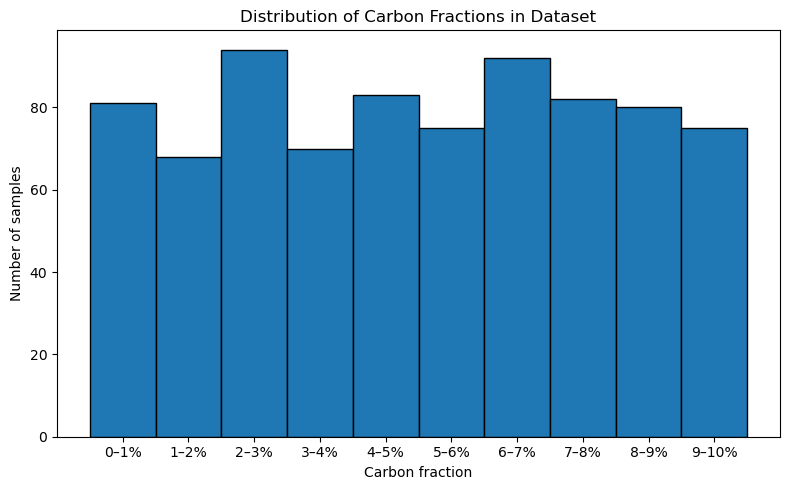

In [4]:
data.plot_carbon_fraction_histogram(train_dataset, element_to_index, bin_range='0-10')

In [5]:
import models
import losses

In [6]:
# Hyperparameter
batch_size = 32
epochs = 20
learning_rate = 1e-4

In [7]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [11]:
# Hyperparameter
batch_size = 32
epochs = 20
learning_rate = 1e-5

In [12]:
# Initialize model
model = models.deeper_CNN_MDN(num_elements=3, num_mixtures=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/20 | Train Loss: 1.4225 | Val Loss: 2.0501
Epoch 2/20 | Train Loss: -1.5967 | Val Loss: -1.2321
Epoch 3/20 | Train Loss: -5.2090 | Val Loss: -5.5874
Epoch 4/20 | Train Loss: -7.3934 | Val Loss: -7.5660
Epoch 5/20 | Train Loss: -7.6115 | Val Loss: -7.7642
Epoch 6/20 | Train Loss: -7.7643 | Val Loss: -7.8298
Epoch 7/20 | Train Loss: -7.8534 | Val Loss: -7.8624
Epoch 8/20 | Train Loss: -7.9093 | Val Loss: -7.9161
Epoch 9/20 | Train Loss: -7.9786 | Val Loss: -8.0336
Epoch 10/20 | Train Loss: -8.0929 | Val Loss: -8.0958
Epoch 11/20 | Train Loss: -8.1468 | Val Loss: -7.9837
Epoch 12/20 | Train Loss: -8.3157 | Val Loss: -8.2351
Epoch 13/20 | Train Loss: -8.3720 | Val Loss: -7.9860
Epoch 14/20 | Train Loss: -8.4801 | Val Loss: -8.3890
Epoch 15/20 | Train Loss: -8.6149 | Val Loss: -8.3373
Epoch 16/20 | Train Loss: -8.7522 | Val Loss: -8.4551
Epoch 17/20 | Train Loss: -8.7524 | Val Loss: -7.6243
Epoch 18/20 | Train Loss: -8.8245 | Val Loss: -8.5953
Epoch 19/20 | Train Loss: -9.2285 | Val

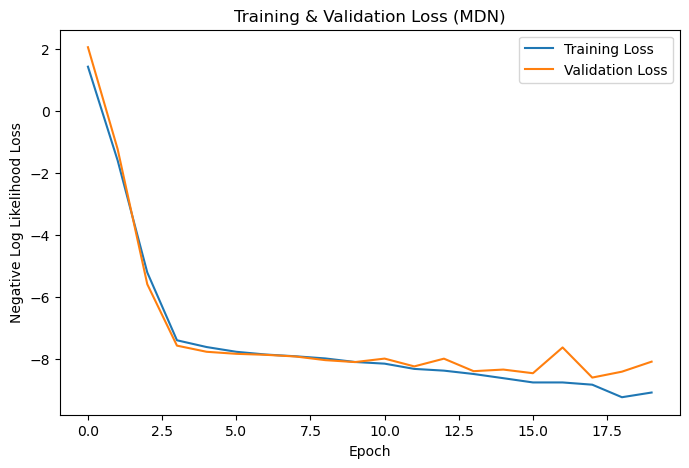

In [13]:
# Training loop
train_losses = []
val_losses = []

gap_history = []
gap_window = 5
early_stop_triggered = False

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        pi, mu, sigma = model(batch_X)
        #sample_weights = compute_asymmetric_sample_weights(batch_Y).to(device)
        loss = losses.mdn_loss(batch_Y, pi, mu, sigma, eps=1e-6)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_Y in val_loader:
            val_X, val_Y = val_X.to(device), val_Y.to(device)
            pi, mu, sigma = model(val_X)
            #sample_weights = compute_asymmetric_sample_weights(val_Y).to(device)
            loss = losses.mdn_loss(val_Y, pi, mu, sigma, eps=1e-6)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    gap = avg_val_loss - avg_train_loss
    gap_history.append(gap)

    if len(gap_history) > gap_window:
        gap_history.pop(0)  # only keep N recent gap value

        if epoch >= 20 and avg_val_loss <= -4:  
            # If N recent gap strictly increasing
            if all(gap_history[i] < gap_history[i + 1] for i in range(gap_window - 1)):
                print(f"Early stop at {gap_window} epochs")
                early_stop_triggered = True
                break

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood Loss")
plt.title("Training & Validation Loss (MDN)")
plt.legend()
plt.show()

In [14]:
import evaluation
import utils

results = evaluation.run_evaluation(model, val_loader, device, utils.mdn_predict_mean, utils.mdn_predict_std)

In [15]:
metrics = evaluation.metrics(results)
print(metrics)

{'MAE': 0.015182439237833023, 'NLL': -7.96035099029541}


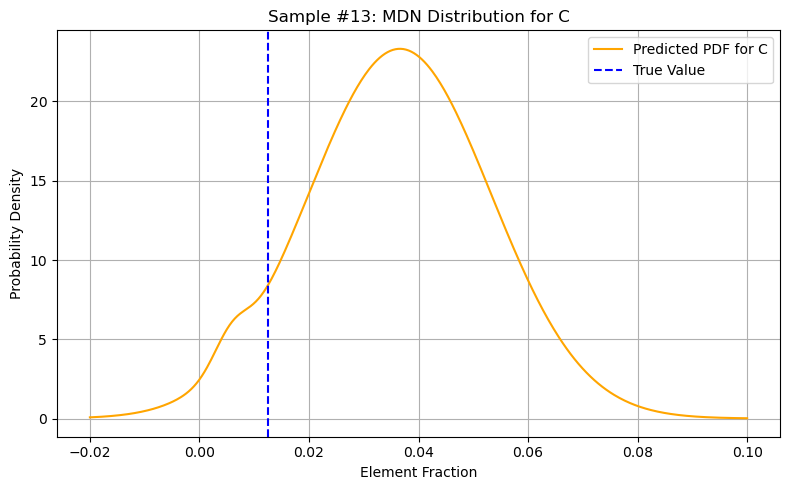

In [16]:
evaluation.plot_mdn_distribution(results, element_list, sample_index=13, element_name="C")

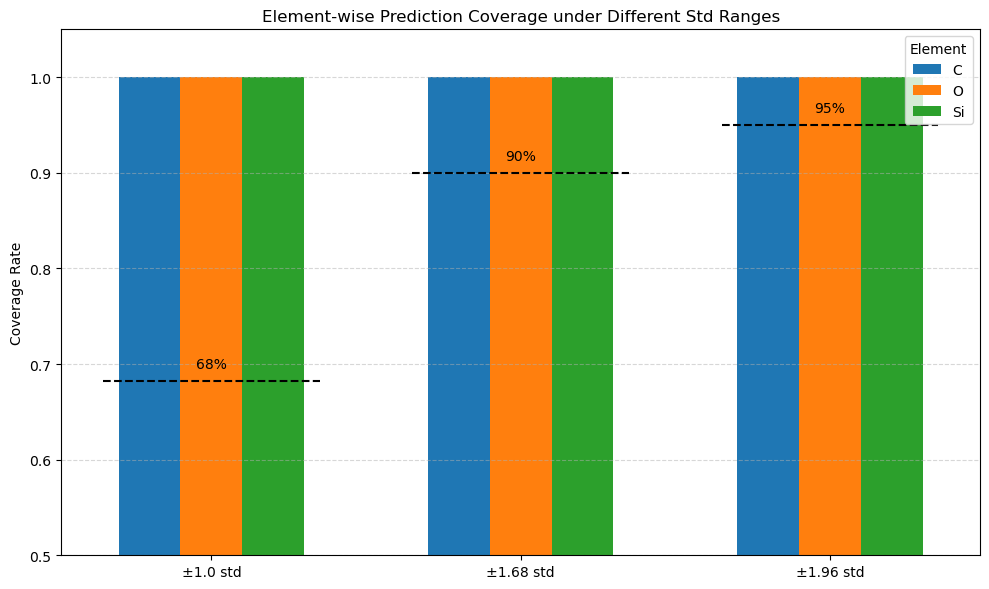

In [17]:
evaluation.plot_uncertainty_coverage(results, element_list, element_to_index)

### Add Sigma penalty to loss function

In [46]:
# Hyperparameter
batch_size = 32
epochs = 30
learning_rate = 1e-4

In [44]:
# Initialize model
model = models.deeper_CNN_MDN(num_elements=3, num_mixtures=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.CNN_MDN(num_elements=3, num_mixtures=3).to(device)
model.load_state_dict(torch.load("../MDN_3_mixture_with_penalty.pt", map_location=device))

<All keys matched successfully>

In [48]:
results = evaluation.run_evaluation(model, val_loader, device, utils.mdn_predict_mean, utils.mdn_predict_std)

In [49]:
metrics = evaluation.metrics(results)
print(metrics)

{'MAE': 0.009380029514431953, 'NLL': -9.908049583435059}


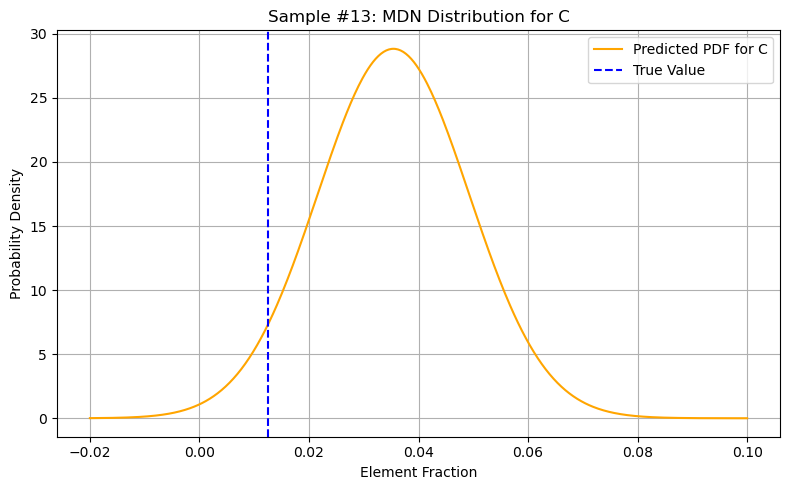

In [50]:
evaluation.plot_mdn_distribution(results, element_list, sample_index=13, element_name="C")

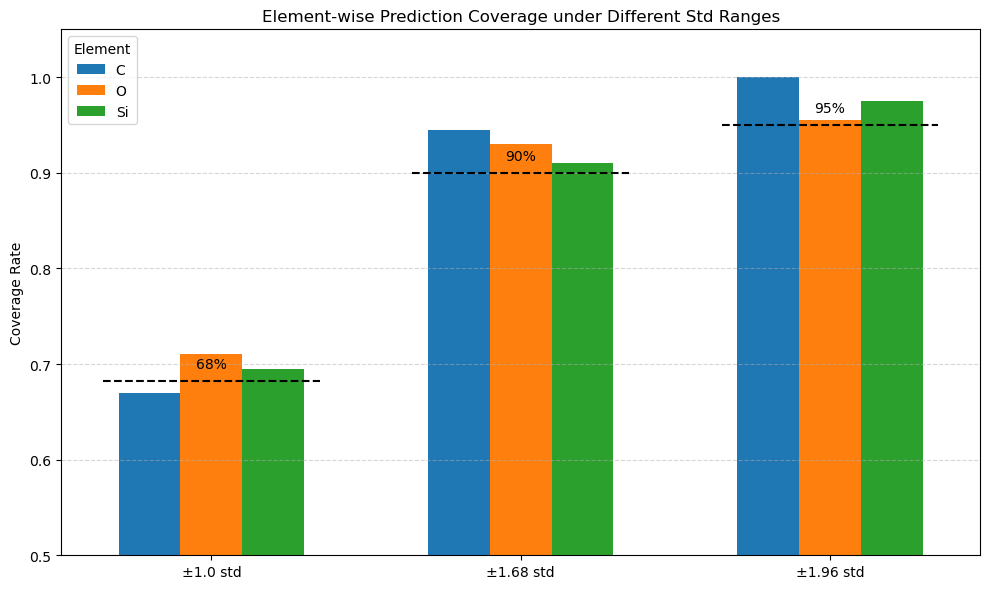

In [51]:
evaluation.plot_uncertainty_coverage(results, element_list, element_to_index)

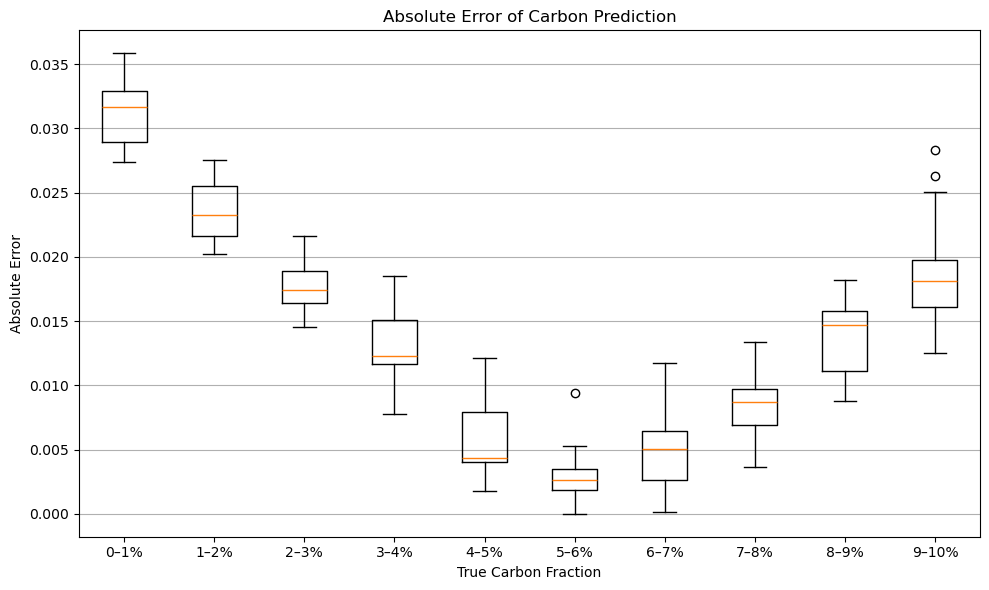

In [52]:
evaluation.plot_carbon_error_boxplot(results, element_to_index, bin_range="0-10")